In [ ]:
!nvidia-smi

Sun Nov 14 17:01:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !ps -aux|grep python

In [ ]:
# !kill -9 92

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/HW2/hw2_data.zip

串流輸出內容已截斷至最後 5000 行。
 extracting: hw2_data/face/train/31182.png  
 extracting: hw2_data/face/train/35296.png  
 extracting: hw2_data/face/train/29882.png  
  inflating: hw2_data/face/train/21095.png  
 extracting: hw2_data/face/train/23957.png  
  inflating: hw2_data/face/train/30313.png  
 extracting: hw2_data/face/train/11616.png  
 extracting: hw2_data/face/train/10447.png  
 extracting: hw2_data/face/train/34172.png  
 extracting: hw2_data/face/train/35917.png  
 extracting: hw2_data/face/train/18720.png  
 extracting: hw2_data/face/train/10484.png  
 extracting: hw2_data/face/train/25579.png  
 extracting: hw2_data/face/train/11294.png  
 extracting: hw2_data/face/train/21343.png  
 extracting: hw2_data/face/train/30592.png  
 extracting: hw2_data/face/train/05946.png  
 extracting: hw2_data/face/train/36061.png  
 extracting: hw2_data/face/train/07383.png  
 extracting: hw2_data/face/train/05793.png  
 extracting: hw2_data/face/train/04351.png  
 extracting: hw2_data/face/train/2

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image, ImageEnhance, ImageOps
from torch.autograd import Variable


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [ ]:
!mkdir /content/hw2_data/face_test
!mv /content/hw2_data/face/test /content/hw2_data/face_test/

In [ ]:
# Root directory for dataset
dataroot = "/content/hw2_data/face"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
              transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.RandomHorizontalFlip(p = 0.5),
                #  transforms.RandomCrop(32),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
              ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

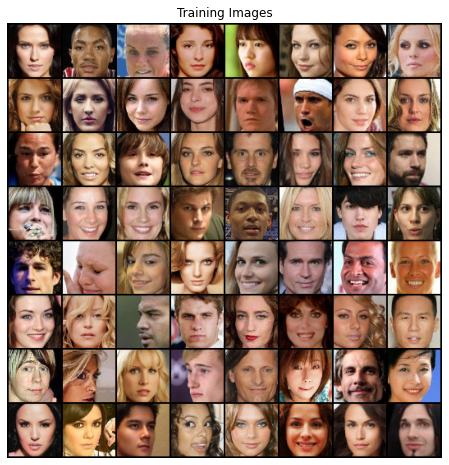

In [ ]:

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The `weights_init` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator
The generator, $G$, is designed to map the latent space vector ($z$) to data-space. Since our data are images, converting $z$ to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[-1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Loss Functions and Optimizers

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
# real_label = 1.
# fake_label = 0.

#label smoothing
real_label = np.random.choice([0.7,0.8,0.9,1,1.1,1.2])
fake_label = np.random.choice([0,0.05,0.1,0.15,0.2,0.25,0.3])

# Setup Adam optimizers for both G and D
# optimizerD = optim.SGD(netD.parameters(), lr=lr)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [ ]:
from tqdm import tqdm
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  G_epoch_losses = []
  D_epoch_losses = []

  if epoch % 10 == 0 and epoch != 0:
    for group in optimizerG.param_groups:
      group['lr'] *= 0.8
    print('learning rate : ', optimizerG.param_groups[0]['lr'])

  # For each batch in the dataloader
  for i, data in enumerate(tqdm(dataloader, 0)):

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      netD.zero_grad()
      # Format batch
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      # Forward pass real batch through D
      output = netD(real_cpu).view(-1)
      # Calculate loss on all-real batch
      errD_real = criterion(output, label)
      # Calculate gradients for D in backward pass
      errD_real.backward()
      D_x = output.mean().item()

      ## Train with all-fake batch
      # Generate batch of latent vectors
      noise = torch.randn(b_size, nz, 1, 1, device=device)
      # Generate fake image batch with G
      fake = netG(noise)
      label.fill_(fake_label)
      # Classify all fake batch with D
      output = netD(fake.detach()).view(-1)
      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(output, label)
      # Calculate the gradients for this batch, accumulated (summed) with previous gradients
      errD_fake.backward()
      D_G_z1 = output.mean().item()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(fake).view(-1)
      # Calculate G's loss based on this output
      errG = criterion(output, label)
      # Calculate gradients for G
      errG.backward()
      D_G_z2 = output.mean().item()
      # Update G
      optimizerG.step()

      # Output training stats
      # if i % 50 == 0:
      #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
      #           % (epoch, num_epochs, i, len(dataloader),
      #               errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      G_epoch_losses.append(errG.item())
      D_epoch_losses.append(errD.item())


      # Check how the generator is doing by saving G's output on fixed_noise
      if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
          with torch.no_grad():
              fake = netG(fixed_noise).detach().cpu()
          img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1
  
  # save model
  if epoch >= 89:
    torch.save(netG.state_dict(),  '/content/drive/MyDrive/HW2/model/dcgan/dcgan_%s.pth'%str(epoch+1)) # 'xxx.pth' #保存模型

  
  print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                % (epoch+1, num_epochs, np.mean(D_epoch_losses), np.mean(G_epoch_losses)))

Starting Training Loop...


100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


[1/100]	Loss_D: 1.3529	Loss_G: 1.7282	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[2/100]	Loss_D: 1.2503	Loss_G: 1.3221	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[3/100]	Loss_D: 1.2364	Loss_G: 1.2848	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[4/100]	Loss_D: 1.2414	Loss_G: 1.2180	


100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


[5/100]	Loss_D: 1.2457	Loss_G: 1.1838	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[6/100]	Loss_D: 1.2565	Loss_G: 1.1346	


100%|██████████| 625/625 [00:39<00:00, 15.97it/s]


[7/100]	Loss_D: 1.2615	Loss_G: 1.1132	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[8/100]	Loss_D: 1.2627	Loss_G: 1.1060	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[9/100]	Loss_D: 1.2695	Loss_G: 1.0832	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[10/100]	Loss_D: 1.2613	Loss_G: 1.0768	
learning rate :  0.00016


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[11/100]	Loss_D: 1.2378	Loss_G: 1.0867	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[12/100]	Loss_D: 1.2256	Loss_G: 1.1188	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[13/100]	Loss_D: 1.2147	Loss_G: 1.1291	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[14/100]	Loss_D: 1.2133	Loss_G: 1.1300	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[15/100]	Loss_D: 1.2186	Loss_G: 1.1206	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[16/100]	Loss_D: 1.2038	Loss_G: 1.1271	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[17/100]	Loss_D: 1.2107	Loss_G: 1.1247	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[18/100]	Loss_D: 1.1922	Loss_G: 1.1526	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[19/100]	Loss_D: 1.2145	Loss_G: 1.1368	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[20/100]	Loss_D: 1.1883	Loss_G: 1.1305	
learning rate :  0.00012800000000000002


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[21/100]	Loss_D: 1.1797	Loss_G: 1.1485	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[22/100]	Loss_D: 1.1766	Loss_G: 1.1563	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[23/100]	Loss_D: 1.1918	Loss_G: 1.1429	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[24/100]	Loss_D: 1.1678	Loss_G: 1.1622	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[25/100]	Loss_D: 1.1683	Loss_G: 1.1722	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[26/100]	Loss_D: 1.1961	Loss_G: 1.1374	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[27/100]	Loss_D: 1.1621	Loss_G: 1.1764	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[28/100]	Loss_D: 1.2054	Loss_G: 1.1443	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[29/100]	Loss_D: 1.1775	Loss_G: 1.1344	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[30/100]	Loss_D: 1.1798	Loss_G: 1.1480	
learning rate :  0.00010240000000000002


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[31/100]	Loss_D: 1.1515	Loss_G: 1.1585	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[32/100]	Loss_D: 1.1533	Loss_G: 1.1715	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[33/100]	Loss_D: 1.1748	Loss_G: 1.1442	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[34/100]	Loss_D: 1.1455	Loss_G: 1.1782	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[35/100]	Loss_D: 1.2206	Loss_G: 1.1091	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[36/100]	Loss_D: 1.1493	Loss_G: 1.1683	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[37/100]	Loss_D: 1.1753	Loss_G: 1.1250	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[38/100]	Loss_D: 1.1418	Loss_G: 1.1797	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[39/100]	Loss_D: 1.1727	Loss_G: 1.1518	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[40/100]	Loss_D: 1.1604	Loss_G: 1.1659	
learning rate :  8.192000000000003e-05


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[41/100]	Loss_D: 1.1287	Loss_G: 1.1698	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[42/100]	Loss_D: 1.1607	Loss_G: 1.1553	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[43/100]	Loss_D: 1.1278	Loss_G: 1.1856	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[44/100]	Loss_D: 1.2025	Loss_G: 1.1068	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[45/100]	Loss_D: 1.1270	Loss_G: 1.1798	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[46/100]	Loss_D: 1.1443	Loss_G: 1.1798	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[47/100]	Loss_D: 1.1299	Loss_G: 1.1793	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[48/100]	Loss_D: 1.1258	Loss_G: 1.1896	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[49/100]	Loss_D: 1.1616	Loss_G: 1.1712	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[50/100]	Loss_D: 1.1217	Loss_G: 1.1786	
learning rate :  6.553600000000003e-05


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[51/100]	Loss_D: 1.1490	Loss_G: 1.1427	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[52/100]	Loss_D: 1.1204	Loss_G: 1.1879	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[53/100]	Loss_D: 1.1297	Loss_G: 1.1843	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[54/100]	Loss_D: 1.1178	Loss_G: 1.1917	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[55/100]	Loss_D: 1.1349	Loss_G: 1.1828	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[56/100]	Loss_D: 1.1163	Loss_G: 1.1889	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[57/100]	Loss_D: 1.1177	Loss_G: 1.1940	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[58/100]	Loss_D: 1.1167	Loss_G: 1.1945	


100%|██████████| 625/625 [00:39<00:00, 16.01it/s]


[59/100]	Loss_D: 1.1364	Loss_G: 1.1724	


100%|██████████| 625/625 [00:38<00:00, 16.03it/s]


[60/100]	Loss_D: 1.1614	Loss_G: 1.1505	
learning rate :  5.242880000000003e-05


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[61/100]	Loss_D: 1.1064	Loss_G: 1.1822	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[62/100]	Loss_D: 1.1412	Loss_G: 1.1697	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[63/100]	Loss_D: 1.1047	Loss_G: 1.1819	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[64/100]	Loss_D: 1.1132	Loss_G: 1.1930	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[65/100]	Loss_D: 1.1292	Loss_G: 1.1737	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[66/100]	Loss_D: 1.1095	Loss_G: 1.1896	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[67/100]	Loss_D: 1.1449	Loss_G: 1.1620	


100%|██████████| 625/625 [00:39<00:00, 16.02it/s]


[68/100]	Loss_D: 1.1049	Loss_G: 1.1782	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[69/100]	Loss_D: 1.1424	Loss_G: 1.1535	


100%|██████████| 625/625 [00:39<00:00, 15.97it/s]


[70/100]	Loss_D: 1.1430	Loss_G: 1.1546	
learning rate :  4.1943040000000025e-05


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[71/100]	Loss_D: 1.1033	Loss_G: 1.1753	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[72/100]	Loss_D: 1.1055	Loss_G: 1.1845	


100%|██████████| 625/625 [00:39<00:00, 15.92it/s]


[73/100]	Loss_D: 1.1025	Loss_G: 1.1873	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[74/100]	Loss_D: 1.1161	Loss_G: 1.1787	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[75/100]	Loss_D: 1.1111	Loss_G: 1.1941	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[76/100]	Loss_D: 1.1520	Loss_G: 1.1135	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[77/100]	Loss_D: 1.0979	Loss_G: 1.1863	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[78/100]	Loss_D: 1.1001	Loss_G: 1.1902	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[79/100]	Loss_D: 1.1364	Loss_G: 1.1529	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[80/100]	Loss_D: 1.0994	Loss_G: 1.1894	
learning rate :  3.355443200000002e-05


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[81/100]	Loss_D: 1.0981	Loss_G: 1.1881	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[82/100]	Loss_D: 1.0998	Loss_G: 1.1906	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[83/100]	Loss_D: 1.2352	Loss_G: 1.0192	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[84/100]	Loss_D: 1.1001	Loss_G: 1.1712	


100%|██████████| 625/625 [00:39<00:00, 15.97it/s]


[85/100]	Loss_D: 1.0963	Loss_G: 1.1831	


100%|██████████| 625/625 [00:39<00:00, 15.93it/s]


[86/100]	Loss_D: 1.1082	Loss_G: 1.1755	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[87/100]	Loss_D: 1.1288	Loss_G: 1.1605	


100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


[88/100]	Loss_D: 1.0928	Loss_G: 1.1787	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[89/100]	Loss_D: 1.1106	Loss_G: 1.1743	


100%|██████████| 625/625 [00:39<00:00, 15.94it/s]


[90/100]	Loss_D: 1.0924	Loss_G: 1.1841	
learning rate :  2.6843545600000018e-05


100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


[91/100]	Loss_D: 1.0938	Loss_G: 1.1893	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[92/100]	Loss_D: 1.1186	Loss_G: 1.1734	


100%|██████████| 625/625 [00:39<00:00, 15.94it/s]


[93/100]	Loss_D: 1.0888	Loss_G: 1.1801	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[94/100]	Loss_D: 1.0934	Loss_G: 1.1876	


100%|██████████| 625/625 [00:39<00:00, 15.95it/s]


[95/100]	Loss_D: 1.1144	Loss_G: 1.1713	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[96/100]	Loss_D: 1.0887	Loss_G: 1.1830	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[97/100]	Loss_D: 1.1384	Loss_G: 1.1448	


100%|██████████| 625/625 [00:39<00:00, 15.99it/s]


[98/100]	Loss_D: 1.0877	Loss_G: 1.1773	


100%|██████████| 625/625 [00:39<00:00, 16.00it/s]


[99/100]	Loss_D: 1.0939	Loss_G: 1.1813	


100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


[100/100]	Loss_D: 1.0934	Loss_G: 1.1850	


# Prediction

In [ ]:
import torch as t

model1 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_100.pth')
model2 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_99.pth')
model3 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_98.pth')
model4 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_97.pth')
model5 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_96.pth')
model6 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_95.pth')
model7 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_94.pth')
model8 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_93.pth')
model9 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_92.pth')
model10 = t.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_91.pth')

for key, value in model1.items():
      model1[key] = (value + model2[key] + model3[key] + model4[key] + model5[key] + model6[key] + model7[key] + model8[key] + model9[key] + model10[key]) / 10

ensemble = Generator(ngpu).to(device)
ensemble.load_state_dict(model1)

t.save(ensemble.state_dict(),  '/content/drive/MyDrive/HW2/model/dcgan/dcgan_ensemble.pth')

In [ ]:
val_dataset = dset.ImageFolder(root='/content/hw2_data/face_test/',transform=transforms.Compose([
                               transforms.Resize(image_size),
                              #  transforms.RandomCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                           ]))
# Create the dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, num_workers=1)
pred = []


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/dcgan/dcgan_ensemble.pth'))

netG.eval()
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

for i, data in enumerate(val_dataloader, 0):
  noise = torch.randn(1, nz, 1, 1, device=device)
  fake = netG(noise).detach().cpu()
  pred.append(fake)



In [ ]:
torch.randn(1, nz, 1, 1, device=device).shape

torch.Size([1, 100, 1, 1])

In [ ]:
try:
  os.system('rm -r /content/test')
except:
  pass

!mkdir /content/test
!mkdir /content/test/testfolder

def Save_image(image_list):
  c=0
  for img in image_list:
    Image.fromarray(((np.transpose(vutils.make_grid(img, padding=2, normalize=True), (1,2,0))).numpy()*255).astype(np.uint8)).save('/content/test/testfolder/%s.png'%c)
    c+=1

Save_image(pred)

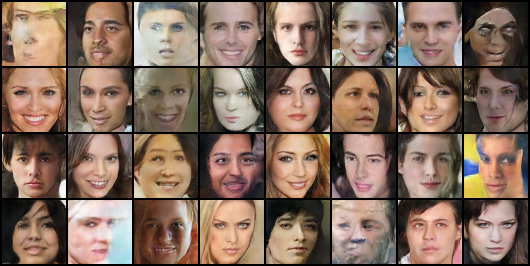

In [ ]:
cuda = True if torch.cuda.is_available() else False

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def show_image(n_row, latent_dim):
  np.random.seed(0)

  z = Variable(FloatTensor(np.random.normal(0, 1, (n_row * 4, latent_dim))))
  z = z.reshape(n_row * 4, latent_dim, 1, 1)

  fake = netG(z).detach().cpu()

  return fake
  # save_image(gen_imgs.data, "/content/train_image/%d.png" % batches_done, nrow=n_row, normalize=True)

demo_img = show_image(n_row=8, latent_dim=nz)
Image.fromarray(((np.transpose(vutils.make_grid(demo_img.cpu(),nrow=8, padding=2, normalize=True), (1,2,0))).numpy()*255).astype(np.uint8))

# Evaluation

## FID score
https://github.com/mseitzer/pytorch-fid

In [ ]:
!pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=b9316bb02f87bfbda09d516ac09f2a7a262e2c112317769f2628d3f0d1b747ac
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


In [ ]:
!python3 -m pytorch_fid /content/hw2_data/face_test/test /content/test/testfolder # 10

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:04<00:00, 20.9MB/s]
100% 53/53 [00:05<00:00,  9.11it/s]
100% 53/53 [00:05<00:00,  9.20it/s]
FID:  22.067702406861343


## Inception Score

In [ ]:
!cp /content/drive/MyDrive/HW2/IS.py /content/IS.py
!python3 IS.py --folder /content/test/testfolder

Load file from : /content/test/testfolder
2620/2621
Loading file completed.
Calculating Inception Score...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100% 104M/104M [00:01<00:00, 88.3MB/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
IS.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()
(2.044722546479866, 0.03681183473811751)
